## Predicting Traffic Demand in California
Vikram Reddy
10/25/2017

Using NHTS data, CHTS data, and data dictionaries

## Table of Contents

### [0. Imported Modules](#Imported-Modules)
### [1. Load Data](#Load-Data)
### [1.5. What am I looking for - Traffic Demand](#Predicting-Traffic-Demand)
### [2. Transform Data](#Transform-Data)
### [3. Descriptive Statistics](#Descriptive-Statistics)
### [4. Baseline Models](#Baseline-Models)
### [5. Error Analysis](#Error-Analysis)
### [6. Change the Baseline](#Change-the-Baseline)
### [7. Decision Tree](#Decision-Tree)
### [8. Ensemble Methods](#Ensemble-Methods)
### [9. Summary](#Summary)

### Imported Modules
[Top](#Table-of-Contents)

In [51]:
# Tables, Queries, and Stats
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sbn

# Data Partitioning
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Decision Tree Model and Plotting
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Error Analysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Computational Performance
import time

# OS, path, system access
import os
import os.path

### Load Data
[Top](#Table-of-Contents)

### There are 9 different Survey Tables in the CHTS

In [53]:
def get_tables_in(data_dir):
    tables_caltrans = [files for root, dirs, files in os.walk(os.getcwd() +\
                                                    data_dir, topdown=True, followlinks=False)][0]
    return tables_caltrans

In [54]:
caltrans_tables = get_tables_in('/caltrans_full_survey/')

In [60]:
def make_dfs_from_files(file_list, table_type, data_dir='caltrans_full_survey/'):
    ''' Create Pandas DataFrames from the list of data files in CHTS. The 
    table_type signifies the group that the data belongs to.
    Possible groups: Surveys, Vehicles, Wearables
    '''
    start = time.time()
    subset_tables = {}
    if table_type == 'survey tables':
        subset = [file for file in file_list if file.startswith('survey_')]
    if table_type == 'vehicle tables':
        subset = [file for file in file_list if file.startswith('v_')]
    if table_type == 'wearable tables':
        subset = [file for file in file_list if file.startswith('w_')]
    for file in subset:
        df = pd.read_csv(data_dir + file, low_memory=False)
        subset_tables[file] = df
    end = time.time()
    print('Loading the {} took {:.3f} seconds.'.format(table_type, end - start))
    return subset_tables

In [61]:
survey_tables = make_dfs_from_files(caltrans_tables, table_type='survey tables')
vehicle_tables = make_dfs_from_files(caltrans_tables, table_type='vehicle tables')
wearable_tables = make_dfs_from_files(caltrans_tables, table_type='wearable tables')

Loading the survey tables took 10.792 seconds.
Loading the vehicle tables took 1.511 seconds.
Loading the wearable tables took 15.904 seconds.


#### Survey of Households, Survey Tables, California Travel Housing Survey

I will begin the exploration with survey of households

In [64]:
survey_tables.keys()

dict_keys(['survey_activity.csv', 'survey_households.csv', 'survey_households_wgts.csv', 'survey_longtrips.csv', 'survey_longtrips_v02.csv', 'survey_person.csv', 'survey_person_wgts.csv', 'survey_place.csv', 'survey_vehicles.csv'])

In [65]:
df_households = survey_tables['survey_households.csv']

In [66]:
df = df_households.copy()

#### Null Counts in the data

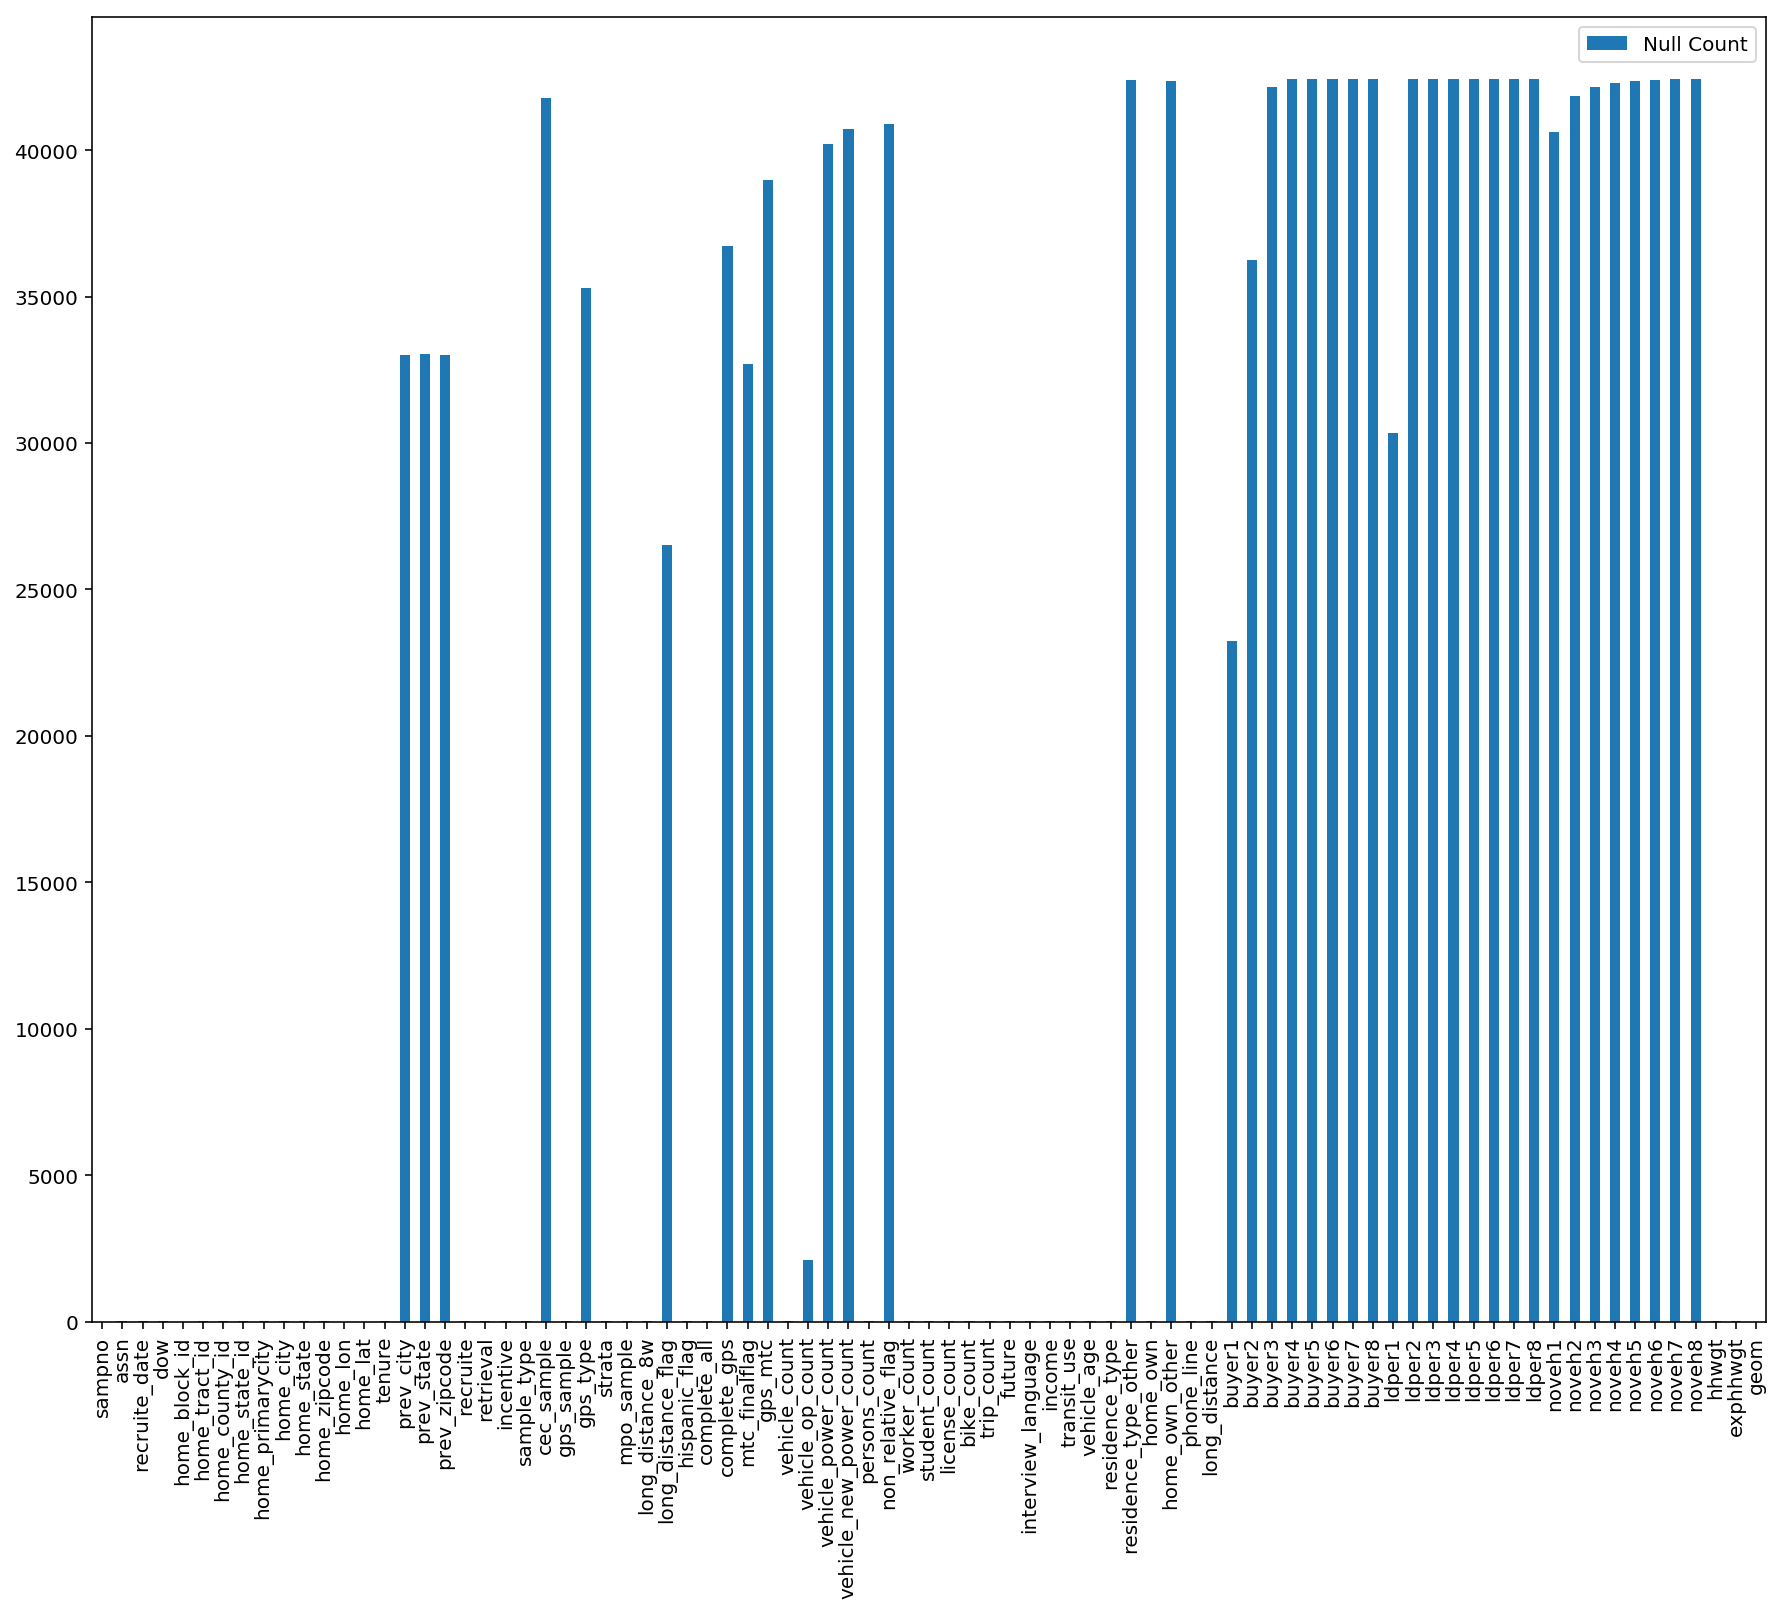

In [68]:
pd.DataFrame(df.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(15,12));

In [69]:
df.head()

,sampno,assn,recruite_date,dow,home_block_id,home_tract_id,home_county_id,home_state_id,home_primarycity,home_city,...,noveh2,noveh3,noveh4,noveh5,noveh6,noveh7,noveh8,hhwgt,exphhwgt,geom
0,2973777,12866.0,2013-01-25,1.0,REDACTED,6.053001e+09,53.0,6.0,SALINAS,SALINAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.309271,90.622952,REDACTED
1,2973814,12866.0,2013-01-08,1.0,REDACTED,6.053001e+09,53.0,6.0,SALINAS,SALINAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.248174,72.720467,REDACTED
2,2973902,13119.0,2013-02-13,6.0,REDACTED,6.053011e+09,53.0,6.0,SALINAS,SALINAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.277319,81.260408,REDACTED
3,2974182,12773.0,2012-11-02,6.0,REDACTED,6.053001e+09,53.0,6.0,SALINAS,SALINAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.343076,100.528612,REDACTED
4,2976556,12855.0,2013-01-08,4.0,REDACTED,6.053015e+09,53.0,6.0,SALINAS,SALINAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.173203,50.752359,REDACTED


In [70]:
df.columns

Index(['sampno', 'assn', 'recruite_date', 'dow', 'home_block_id',
       'home_tract_id', 'home_county_id', 'home_state_id', 'home_primarycity',
       'home_city', 'home_state', 'home_zipcode', 'home_lon', 'home_lat',
       'tenure', 'prev_city', 'prev_state', 'prev_zipcode', 'recruite',
       'retrieval', 'incentive', 'sample_type', 'cec_sample', 'gps_sample',
       'gps_type', 'strata', 'mpo_sample', 'long_distance_8w',
       'long_distance_flag', 'hispanic_flag', 'complete_all', 'complete_gps',
       'mtc_finalflag', 'gps_mtc', 'vehicle_count', 'vehicle_op_count',
       'vehicle_power_count', 'vehicle_new_power_count', 'persons_count',
       'non_relative_flag', 'worker_count', 'student_count', 'license_count',
       'bike_count', 'trip_count', 'future', 'interview_language', 'income',
       'transit_use', 'vehicle_age', 'residence_type', 'residence_type_other',
       'home_own', 'home_own_other', 'phone_line', 'long_distance', 'buyer1',
       'buyer2', 'buyer3', 'buyer4

In [71]:
df.shape

(42426, 83)

In [74]:
df.describe()

,sampno,assn,dow,home_tract_id,home_county_id,home_state_id,home_zipcode,tenure,prev_zipcode,recruite,...,noveh1,noveh2,noveh3,noveh4,noveh5,noveh6,noveh7,noveh8,hhwgt,exphhwgt
count,4.242600e+04,42421.000000,42421.000000,4.242100e+04,42421.000000,42421.0,42421.000000,42421.000000,9422.000000,42421.000000,...,1808.000000,577.000000,270.000000,148.000000,73.000000,32.000000,14.000000,4.000000,42421.000000,42421.000000
mean,2.588798e+06,12726.366328,4.019872,6.056293e+09,56.117418,6.0,93443.389288,16.203767,93888.885056,1.149148,...,6.490597,5.415945,6.885185,8.128378,8.657534,8.875000,8.857143,7.500000,0.999955,293.007784
std,1.641667e+06,132.338463,1.993674,2.944557e+07,29.495531,0.0,1744.625795,13.402723,11409.447189,0.356238,...,10.969239,3.475653,2.910972,2.110165,1.693281,2.324484,2.905092,4.358899,0.704667,206.482227
min,1.031985e+06,12532.000000,1.000000,6.001400e+09,1.000000,6.0,90001.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,0.003498,1.025146
25%,1.662299e+06,12632.000000,2.000000,6.037207e+09,37.000000,6.0,92211.000000,6.000000,92625.250000,1.000000,...,2.000000,3.000000,4.000000,7.000000,8.000000,8.000000,9.000000,7.000000,0.447392,131.095416
50%,1.972002e+06,12707.000000,4.000000,6.059042e+09,59.000000,6.0,93551.000000,12.000000,94952.000000,1.000000,...,4.000000,3.000000,7.000000,9.000000,9.000000,9.000000,9.500000,9.500000,0.915924,268.385115
75%,2.830168e+06,12796.000000,6.000000,6.079011e+09,79.000000,6.0,95020.000000,23.000000,99999.000000,1.000000,...,10.000000,9.000000,9.000000,9.000000,9.000000,10.000000,10.750000,10.000000,1.376790,403.428487
max,7.212388e+06,13132.000000,7.000000,6.115041e+09,115.000000,6.0,97635.000000,99.000000,99999.000000,2.000000,...,99.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,10.000000,5.400840,1582.559559


### Predicting Traffic Demand
[Top](#Table-of-Contents)

Possible research questions:
    - Predicting Traffic Demand for Disabled Population
        - How to quantify Traffic Demand?
             - Is it hours on the road?
             - frequency of using vehicles in a given time period
             - 
             - 
             - Come up with a score that takes into account all of these factors
             - this will be our label
        - How to quantify disability?
             - This one is easier
                 - there is a empl_status field in the survey_person table
                     - 2 means disabled
                 - dis_type[1-7, other] fields in the survey_person table describe this disability.
        - Could be a good advocate for autonomous vehicles if we show there is a high demand for AV from 
        persons with disability
    - Predicting Traffic Demand for Minorities
        - Same deal
    - Predicting Traffic Demand for Autonomous Vehicles
        - Interesting, but need to think about how to define Autonomous vehicles
    - Predicting Traffic Demand for Electric Vehicles
        - Same as the first one, except replace with EV statistics from survey_vehicles table
    -
    - 
    -          

### Transform Data
[Top](#Table-of-Contents)

Let's have a brief look at the data, see if there are any categorical variables, and transform them if so.

### Descriptive Statistics
[Top](#Table-of-Contents)

I will plot how different variables are distributed, detecting how the data is skewed or if there is a normal distribution.

### Baseline Models
[Top](#Table-of-Contents)

In [76]:
def get_features(df, label):
    df_features = df.copy()
    df_features = df_features.drop(label, axis=1)
    return df_features
    
def get_labels(df, label):
    return pd.DataFrame(df[label])

def partition_data(features, labels):
    return train_test_split(features, labels, 
                           test_size=0.3,
                           random_state=549)

In [77]:
all_features = get_features(df, 'put_label_name_here')
all_labels = get_labels(df, 'put_label_name_here')
train_features, test_features, train_labels, test_labels = partition_data(all_features, all_labels)
train_labels = np.ravel(train_labels)
test_labels = np.ravel(test_labels)

ValueError: labels ['put_label_name_here'] not contained in axis

In [65]:
def train_and_test_model(model):
    print()
    print(model)
    print()
    print('Training model...')
    fitted = model.fit(train_features, train_labels)
    print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_binary = predicted.round()
    accuracy = accuracy_score(predicted_binary, test_labels)
    print('This model\'s accuracy is {}'.format(accuracy))
    return predicted, accuracy

def get_predictions_and_scores(all_models):
    '''
    Store the predictions and scores in a list of tuples, that can be sorted based on a key. The key is the
    accuracy of each model.
    
    Returns the highest score and corresponding prediction of labels.
    '''
    predictions_and_accuracies = [train_and_test_model(model) for model in all_models]
    return max(predictions_and_accuracies, key=lambda x: x[1])

In [66]:
all_models = [LinearRegression(), LogisticRegression(), BernoulliNB()]
max_score_for_prediction = get_predictions_and_scores(all_models)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Training model...
Test the model.
This model's accuracy is 0.9687961205987772

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training model...
Test the model.
This model's accuracy is 0.9856841661395741

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training model...
Test the model.
This model's accuracy is 0.9671832173729706


In [72]:
print('The best model has a score of {:.2f} percent.'.format(max_score_for_prediction[1]*100))

The best model has a score of 98.57 percent.


## Error Analysis
[Top](#Table-of-Contents)

I will plot a confusion matrix to show how many false positives, false negatives, true positives, and true negative I classified using my model.

In [96]:
# Refer to Seaborn Heatmap docs here to select color map:
# http://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
def plot_confusion_matrix(cm, labels,
                          title='Confusion matrix',
                         cmap=None):
    
    plt.figure(figsize=(8,8))

    sbn.heatmap(cm,
               annot=True,
               fmt='d',
               linewidths=0.5,
               cmap=cmap)
    
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

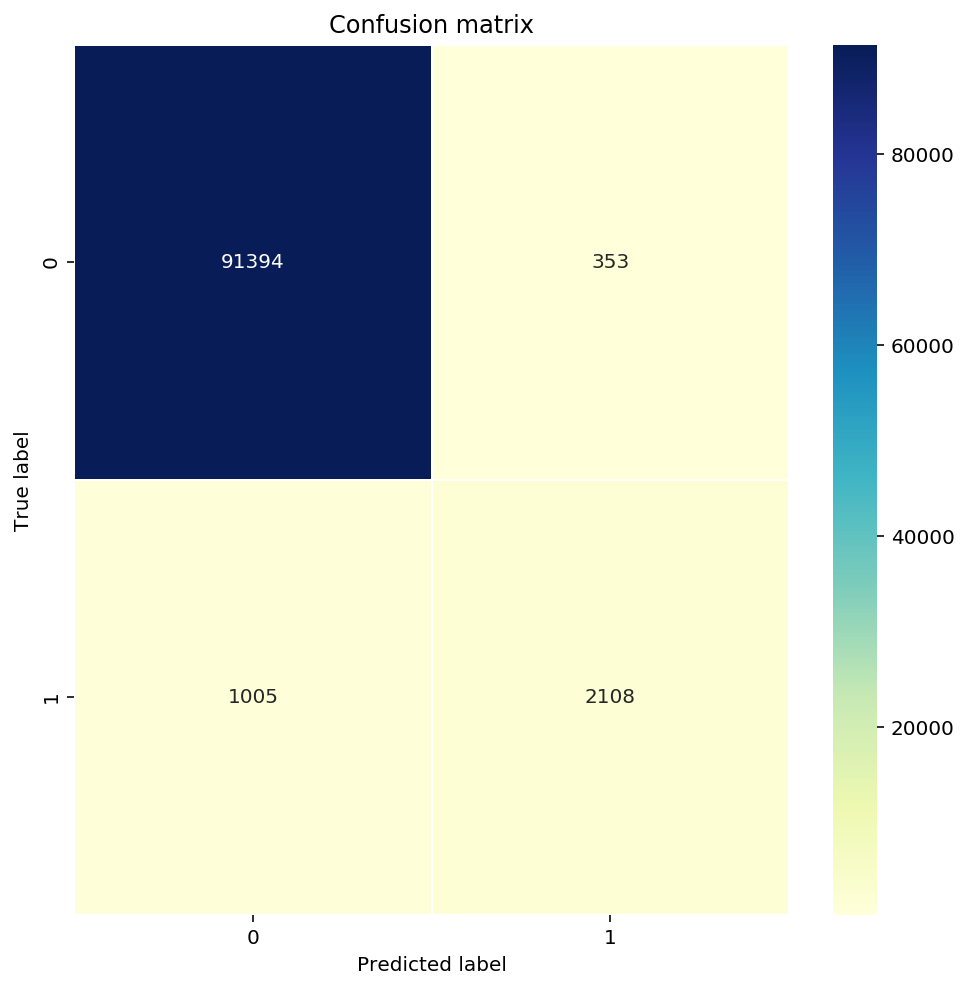

In [97]:
cm = confusion_matrix(test_labels, max_score_for_prediction[0])
plot_confusion_matrix(cm, 
                     labels=['Demand < threshold','Demand > threshold'],
                     cmap="YlGnBu")

## Change the Baseline
[Top](#Table-of-Contents)

In [78]:
#baseline_accuracy = accuracy_score(np.zeros(len(test_labels)), test_labels)
print('The baseline for predicting demand > threshold for all instances is {:.2f}.'.format(baseline_accuracy*100))

NameError: name 'baseline_accuracy' is not defined

The result is a 96.7% accuracy score.

Next, I will try to use Decision Trees to interpret my models and use Ensemble Methods to optimize the accuracy.

## Decision Trees
[Top](#Table-of-Contents)

In [86]:
def run_model(model):
    print()
    print('Training the model (Fitting to the training data) ')
    fitted = model.fit(train_features, train_labels)
    print('Fitted model: {}'.format(fitted))
    predicted_labels = fitted.predict(test_features)
    accuracy = accuracy_score(predicted_labels, test_labels)
    print('The accuracy for the decision tree classifier is {}'.format(accuracy*100))
    return fitted

def decision_tree():
    return run_model(DecisionTreeClassifier(max_leaf_nodes=9))

In [87]:
dt_classifier = decision_tree()


Training the model (Fitting to the training data) 
Fitted model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=9, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The accuracy for the decision tree classifier is 98.47459413873077


In [89]:
feature_names = all_features.columns
label_names = all_labels.columns
dot_data = export_graphviz(dt_classifier, out_file=None,
               feature_names=feature_names,
                           # check to see if I need to dummy variablize the labels before
                           # running Decision Tree
               class_names=['demand < threshold', 'demand > threshold'],
               filled=True, rounded=True,
               special_characters=True)
#graph = graphviz.Source(dot_data)
graph = pydotplus.graph_from_dot_data(dot_data)

### Ensemble Methods
[Top](#Table-of-Contents)

#### Bagging
Takes the average of _B_ trees grown out of _B_ bootstrapped datasets. A bootstrapped dataset is subsampling with replacement from a single dataset. Bagging reduces the variance of the statistical method and thus improves the accuracy of the resulting classification.

In [99]:
run_model(BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=20),
         max_features=.9, max_samples=0.9));


Training the model (Fitting to the training data) 
Fitted model: BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.9,
         max_samples=0.9, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
The accuracy for the decision tree classifier is 98.5494412818891


#### Random Forests
Setting $$max\space samples = \sqrt{total\space samples}$$ when bagging yields an optimum random forest model

**Finding the optimal subset of features to choose from**

In [93]:
from math import sqrt
sqrt(len(df)) / len(df)

0.0017783574850739467

In [102]:
run_model(RandomForestClassifier(
    n_estimators=100, max_leaf_nodes=20)
    );


Training the model (Fitting to the training data) 
Fitted model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=20,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
The accuracy for the decision tree classifier is 98.4819734345351


## Summary
[Top](#Table-of-Contents)